# 04b - Regression Models for Risk Score Prediction

**Objetivo**: Desarrollar modelos de regresión para predecir el `composite_risk_score` continuo
 
**Modelos a desarrollar**:
- Linear Regression (baseline)
- Random Forest Regressor
- XGBoost Regressor
- Support Vector Regressor
- Neural Network Regressor

---

## Importar Librerías

In [18]:
import sys
import os
sys.path.append('../src/modeling')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import gc
import joblib
import json
from joblib import Memory
warnings.filterwarnings('ignore')
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Importar pipeline de regresión
from regression_pipeline import RegressionPipeline
from model_utils import load_processed_data, save_model_artifacts
import mlflow
import mlflow.sklearn


## Configuraciones

In [2]:
# Configuración
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
print("✅ Librerías y módulos importados correctamente")
print(f"📅 Fecha de ejecución: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Librerías y módulos importados correctamente
📅 Fecha de ejecución: 2025-06-21 16:54:16


In [4]:
# Configuración MLflow
mlflow.set_experiment("alzheimer_multimodal_monitoring")

print("🔧 MLflow configurado para modelos de regresión")
print("🎯 Target: composite_risk_score (regresión continua)")


🔧 MLflow configurado para modelos de regresión
🎯 Target: composite_risk_score (regresión continua)


In [5]:
# Agrega después de tu configuración:
experiment = mlflow.get_experiment_by_name("alzheimer_multimodal_monitoring")
print(f"ID del experimento: {experiment.experiment_id}")
print(f"Ubicación: {experiment.artifact_location}")

ID del experimento: 503314857977141831
Ubicación: file:///E:/usuarios/alumno/Escritorio/Alzheimer-Multimodal-Monitoring/notebooks/mlruns/503314857977141831


## Cargar datos procesados

In [6]:
# Cargar datos procesados
try:
    df = pd.read_csv('../data/processed/features/alzheimer_features_selected_20250621.csv')
    print(f"📊 Dataset cargado: {df.shape}")
    print(f"📈 Registros con score válido: {df['composite_risk_score'].notna().sum()}")
    
    # Información del target
    target_stats = df['composite_risk_score'].describe()
    print(f"\n📊 ESTADÍSTICAS DEL TARGET:")
    print(f"   • Media: {target_stats['mean']:.3f}")
    print(f"   • Desviación estándar: {target_stats['std']:.3f}")
    print(f"   • Rango: [{target_stats['min']:.3f}, {target_stats['max']:.3f}]")
    
except FileNotFoundError:
    print("❌ Error: Archivo no encontrado")
    print("💡 Ejecuta primero el notebook de feature engineering")

📊 Dataset cargado: (48466, 186)
📈 Registros con score válido: 48466

📊 ESTADÍSTICAS DEL TARGET:
   • Media: 0.367
   • Desviación estándar: 0.213
   • Rango: [0.000, 0.929]


In [7]:
col_nonnum = df.select_dtypes(exclude=['number'])
cant_nonnum = col_nonnum.shape[1]
print(f"cantidad de columnas no numericas: {cant_nonnum}")
print(list(col_nonnum))

cantidad de columnas no numericas: 9
['PTGENDER', 'update_stamp_apoe_normalized', 'subject_id_activity', 'PTID_apoe', 'gender_normalized', 'EDUCATION_LEVEL', 'update_stamp_apoe', 'gender', 'risk_category']


In [8]:
# Inicializar pipeline de regresión
regression_pipeline = RegressionPipeline(
    target_col='composite_risk_score',
    test_size=0.2,
    random_state=42
)

print("🔧 Pipeline de regresión inicializado")
print(f"   • Target: {regression_pipeline.target_col}")
print(f"   • Test size: {regression_pipeline.test_size}")

🔧 Pipeline de regresión inicializado
   • Target: composite_risk_score
   • Test size: 0.2


## Separación de datos en características (X) y variable objetivo (y)

In [9]:
# Separar características (X) y variable objetivo (y)
X = df.drop(columns=['composite_risk_score'])  # Todas las columnas excepto el target
y = df['composite_risk_score']  # Solo la columna objetivo

# Verificar las dimensiones
print(f"🔍 Dimensiones de los datos:")
print(f"   • X: {X.shape} (features)")
print(f"   • y: {y.shape} (target)")

🔍 Dimensiones de los datos:
   • X: (48466, 185) (features)
   • y: (48466,) (target)


In [10]:
print("Valores faltantes en X:", X.isna().sum().sum())
print("Valores faltantes en y:", y.isna().sum())

Valores faltantes en X: 1073107
Valores faltantes en y: 0


## Ejecución del Pipeline y Manejo de NaN

In [11]:
# Limpiar caché de joblib
mem = Memory(location=None)
mem.clear()

# Limpiar caché de MLflow (opcional)
mlflow.end_run()

[Memory(location=None)]: Flushing completely the cache


In [12]:
# 1. Eliminar columnas no numéricas
non_numeric = ['gender', 'update_stamp_apoe_normalized', 'update_stamp_apoe', 
              'PTGENDER', 'subject_id_activity', 'PTID_apoe', 'EDUCATION_LEVEL', 
              'gender_normalized', 'risk_category']
X = X.drop(columns=non_numeric, errors='ignore')  # 'errors=ignore' evita errores si alguna columna no existe

# 2. Reemplazar infinitos por NaN
print(f"Valores infinitos antes: {np.isinf(X.values).sum()}")
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# 3. Identificar y eliminar columnas completamente vacías
empty_cols = X.columns[X.isna().all()].tolist()
print(f"\n🔥 Columnas completamente vacías ({len(empty_cols)}): {empty_cols}")
X = X.drop(columns=empty_cols)

# 4. Imputar valores faltantes
print(f"\nValores NaN en X antes de imputar: {X.isna().sum().sum()}")
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# 5. Crear nuevo DataFrame manteniendo solo las columnas no vacías
X = pd.DataFrame(X_imputed, columns=X.columns)

# 6. Verificar resultados
print(f"\nValores infinitos después: {np.isinf(X.values).sum()}")
print(f"Valores NaN después de imputar: {X.isna().sum().sum()}")
print(f"Nuevas dimensiones: {X.shape}")

# Liberar memoria explícitamente
gc.collect()

# Ejecutar el pipeline completo de regresión para todos los modelos
results = regression_pipeline.run_regression_pipeline(
    X,  # Features 
    y,  # Target 
    optimize_hyperparams=False,  # No optimizar hiperparámetros
    cross_validate=True          # Realizar validación cruzada
)

print("✅ Pipeline completo ejecutado!")

Valores infinitos antes: 338099

🔥 Columnas completamente vacías (10): ['CDRSB_LOG_normalized', 'CDRSB_CHANGE_ANNUAL_normalized', 'CDRSB_CHANGE_normalized', 'CDRSB_threshold_distance', 'CDRSB_CHANGE_threshold_distance', 'CDRSB_CHANGE_ANNUAL_threshold_distance', 'CDRSB_normalized', 'CDRSB_CATEGORY_threshold_distance', 'CDRSB_CATEGORY_normalized', 'CDRSB_LOG_threshold_distance']

Valores NaN en X antes de imputar: 891008

Valores infinitos después: 0
Valores NaN después de imputar: 0
Nuevas dimensiones: (48466, 166)
 Configurados 9 modelos de regresión

🚀 INICIANDO PIPELINE DE REGRESIÓN
   • Dimensiones entrenamiento: (38772, 166)
   • Dimensiones test: (9694, 166)

 Entrenando linear_regression...
📊 RMSE: 0.0229
📊 MAE: 0.0148
📊 R²: 0.9884
📊 CV RMSE: 0.0218 ± 0.0008
🔍 Verificación final de métricas para linear_regression:
   ✓ rmse: 0.022932037354607946
   ✓ mae: 0.014813615278081484
   ✓ r2_score: 0.9883600797229593
   ✓ cv_rmse_mean: 0.021814137080234743
   ✓ cv_rmse_std: 0.00082922001

2025/06/21 17:00:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


💾 Modelo guardado: ../models/regression_linear_regression_model.joblib

 Entrenando ridge...
📊 RMSE: 0.0229
📊 MAE: 0.0148
📊 R²: 0.9884
📊 CV RMSE: 0.0218 ± 0.0008
🔍 Verificación final de métricas para ridge:
   ✓ rmse: 0.02293658795653361
   ✓ mae: 0.014836762967297381
   ✓ r2_score: 0.98835545964509
   ✓ cv_rmse_mean: 0.021822820348587787
   ✓ cv_rmse_std: 0.0008314835626724497
✅ Métricas registradas en MLflow para ridge


2025/06/21 17:01:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


💾 Modelo guardado: ../models/regression_ridge_model.joblib

 Entrenando lasso...
📊 RMSE: 0.2126
📊 MAE: 0.1851
📊 R²: -0.0000
📊 CV RMSE: 0.2129 ± 0.0016
🔍 Verificación final de métricas para lasso:
   ✓ rmse: 0.2125531991849336
   ✓ mae: 0.18506606662358502
   ✓ r2_score: -3.857375974192223e-08
   ✓ cv_rmse_mean: 0.2129283441305299
   ✓ cv_rmse_std: 0.0016034006046739787
✅ Métricas registradas en MLflow para lasso


2025/06/21 17:01:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


💾 Modelo guardado: ../models/regression_lasso_model.joblib

 Entrenando elastic_net...
📊 RMSE: 0.2126
📊 MAE: 0.1851
📊 R²: -0.0000
📊 CV RMSE: 0.2129 ± 0.0016
🔍 Verificación final de métricas para elastic_net:
   ✓ rmse: 0.2125531991849336
   ✓ mae: 0.18506606662358502
   ✓ r2_score: -3.857375974192223e-08
   ✓ cv_rmse_mean: 0.2129283441305299
   ✓ cv_rmse_std: 0.0016034006046739787
✅ Métricas registradas en MLflow para elastic_net


2025/06/21 17:02:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


💾 Modelo guardado: ../models/regression_elastic_net_model.joblib

 Entrenando random_forest...
📊 RMSE: 0.0106
📊 MAE: 0.0037
📊 R²: 0.9975
📊 CV RMSE: 0.0104 ± 0.0004
🔍 Verificación final de métricas para random_forest:
   ✓ rmse: 0.010567535280272511
   ✓ mae: 0.003679117300422393
   ✓ r2_score: 0.9975282067748472
   ✓ cv_rmse_mean: 0.010435571034732078
   ✓ cv_rmse_std: 0.00038645832968612416
✅ Métricas registradas en MLflow para random_forest


2025/06/21 17:33:01 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\alumno\AppData\Local\Temp\tmpjp3qh9ts\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/06/21 17:33:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


💾 Modelo guardado: ../models/regression_random_forest_model.joblib

 Entrenando gradient_boosting...
📊 RMSE: 0.0129
📊 MAE: 0.0073
📊 R²: 0.9963
📊 CV RMSE: 0.0126 ± 0.0004
🔍 Verificación final de métricas para gradient_boosting:
   ✓ rmse: 0.012883843223785186
   ✓ mae: 0.007337607789060398
   ✓ r2_score: 0.9963258609559333
   ✓ cv_rmse_mean: 0.012616852784948219
   ✓ cv_rmse_std: 0.00043512816541404765
✅ Métricas registradas en MLflow para gradient_boosting


2025/06/21 17:52:47 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\alumno\AppData\Local\Temp\tmpuyi3jupk\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/06/21 17:52:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


💾 Modelo guardado: ../models/regression_gradient_boosting_model.joblib

 Entrenando svr...
📊 RMSE: 0.0532
📊 MAE: 0.0431
📊 R²: 0.9373
📊 CV RMSE: 0.0544 ± 0.0003
🔍 Verificación final de métricas para svr:
   ✓ rmse: 0.05321673792136848
   ✓ mae: 0.043065869831223874
   ✓ r2_score: 0.9373153472987076
   ✓ cv_rmse_mean: 0.05438949845732548
   ✓ cv_rmse_std: 0.00033485751055700714
✅ Métricas registradas en MLflow para svr


2025/06/21 18:01:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


💾 Modelo guardado: ../models/regression_svr_model.joblib

 Entrenando xgboost...
📊 RMSE: 0.0047
📊 MAE: 0.0023
📊 R²: 0.9995
📊 CV RMSE: 0.0047 ± 0.0002
🔍 Verificación final de métricas para xgboost:
   ✓ rmse: 0.0047284855431525595
   ✓ mae: 0.002319944585647466
   ✓ r2_score: 0.9995051097977002
   ✓ cv_rmse_mean: 0.004738302873513897
   ✓ cv_rmse_std: 0.00021637189767161625
✅ Métricas registradas en MLflow para xgboost


2025/06/21 18:03:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


💾 Modelo guardado: ../models/regression_xgboost_model.joblib

 Entrenando neural_network...
📊 RMSE: 0.0058
📊 MAE: 0.0040
📊 R²: 0.9993
📊 CV RMSE: 5.6493 ± 1.1729
🔍 Verificación final de métricas para neural_network:
   ✓ rmse: 0.005781236328951817
   ✓ mae: 0.004021524215635735
   ✓ r2_score: 0.9992602138933344
   ✓ cv_rmse_mean: 5.649280068182063
   ✓ cv_rmse_std: 1.1729338162831677
✅ Métricas registradas en MLflow para neural_network


2025/06/21 18:25:22 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\alumno\AppData\Local\Temp\tmp_tt6vlmu\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.6.1', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/06/21 18:25:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


💾 Modelo guardado: ../models/regression_neural_network_model.joblib
✅ Pipeline completo ejecutado!


## Comparación de modelos

In [13]:
# Comparación de modelos
models_comparison = {
     'Linear Regression': results['linear_regression'],
     'Random Forest': results['random_forest'],
     'XGBoost': results.get('xgboost', {}),
     'SVR': results['svr'],
     'Neural Network': results.get('neural_network', {})
}

# Crear DataFrame de comparación
comparison_df = pd.DataFrame({
    model_name: {
        'R² Score': metrics['r2_score'],
        'RMSE': metrics['rmse'],
        'MAE': metrics['mae'],
        'Training Time (s)': metrics.get('training_time', 0)  # Usar 0 si no existe
    }
    for model_name, metrics in models_comparison.items()
}).T

print("\n📊 COMPARACIÓN DE MODELOS DE REGRESIÓN")
print("=" * 60)
print(comparison_df.round(4))


📊 COMPARACIÓN DE MODELOS DE REGRESIÓN
                   R² Score    RMSE     MAE  Training Time (s)
Linear Regression    0.9884  0.0229  0.0148                0.0
Random Forest        0.9975  0.0106  0.0037                0.0
XGBoost              0.9995  0.0047  0.0023                0.0
SVR                  0.9373  0.0532  0.0431                0.0
Neural Network       0.9993  0.0058  0.0040                0.0


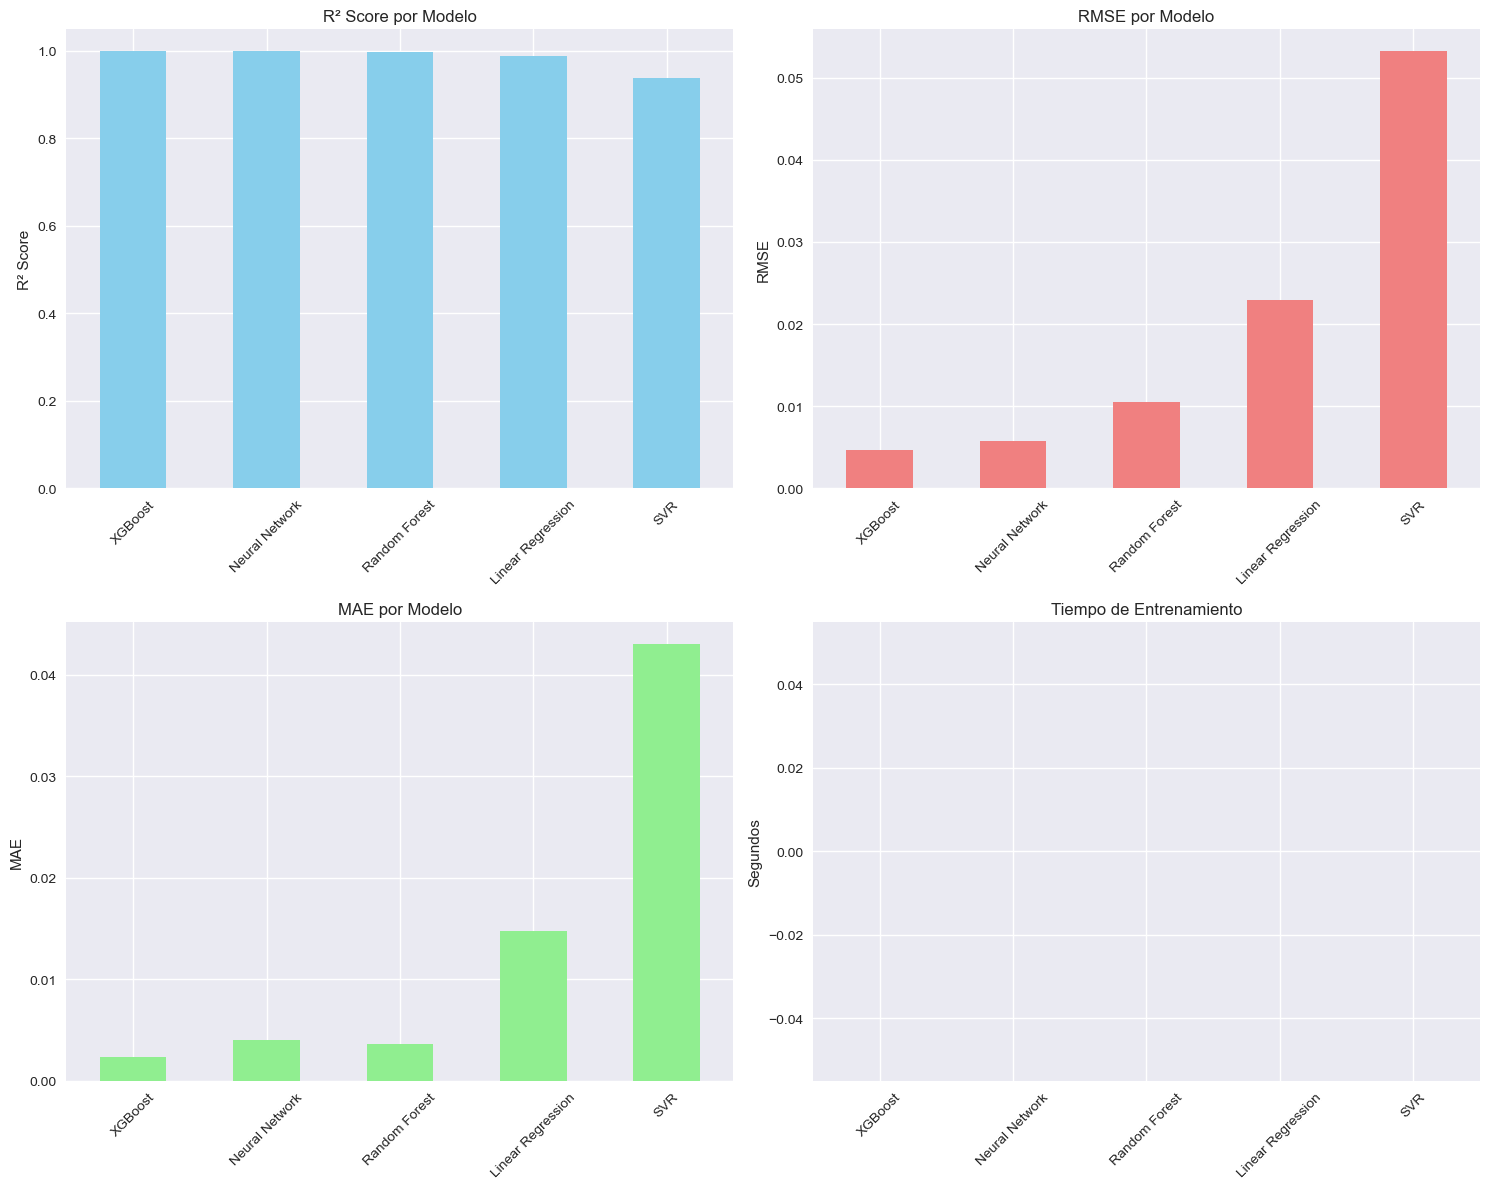

In [14]:
# Ordenar por R² Score (opcional pero útil)
comparison_df = comparison_df.sort_values('R² Score', ascending=False)

# Visualizaciones de comparación
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# R² Score comparison
comparison_df['R² Score'].plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('R² Score por Modelo')
axes[0,0].set_ylabel('R² Score')
axes[0,0].tick_params(axis='x', rotation=45)

# RMSE comparison
comparison_df['RMSE'].plot(kind='bar', ax=axes[0,1], color='lightcoral')
axes[0,1].set_title('RMSE por Modelo')
axes[0,1].set_ylabel('RMSE')
axes[0,1].tick_params(axis='x', rotation=45)

# MAE comparison
comparison_df['MAE'].plot(kind='bar', ax=axes[1,0], color='lightgreen')
axes[1,0].set_title('MAE por Modelo')
axes[1,0].set_ylabel('MAE')
axes[1,0].tick_params(axis='x', rotation=45)

# Training Time comparison
if 'Training Time (s)' in comparison_df.columns:
    comparison_df['Training Time (s)'].plot(kind='bar', ax=axes[1,1], color='orange')
    axes[1,1].set_title('Tiempo de Entrenamiento')
    axes[1,1].set_ylabel('Segundos')
    axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Identificar mejor modelo

In [15]:
# Identificar mejor modelo
best_model_r2 = comparison_df['R² Score'].idxmax()
best_model_rmse = comparison_df['RMSE'].idxmin()
best_model_mae = comparison_df['MAE'].idxmin()

print(f"\n🏆 MEJORES MODELOS POR MÉTRICA:")
print(f"   • Mejor R² Score: {best_model_r2} ({comparison_df.loc[best_model_r2, 'R² Score']:.4f})")
print(f"   • Mejor RMSE: {best_model_rmse} ({comparison_df.loc[best_model_rmse, 'RMSE']:.4f})")
print(f"   • Mejor MAE: {best_model_mae} ({comparison_df.loc[best_model_mae, 'MAE']:.4f})")

# Modelo recomendado (mejor balance)
comparison_df['Score_Compuesto'] = (
    comparison_df['R² Score'] * 0.4 +
    (1 - comparison_df['RMSE'] / comparison_df['RMSE'].max()) * 0.3 +
    (1 - comparison_df['MAE'] / comparison_df['MAE'].max()) * 0.3
)

best_overall = comparison_df['Score_Compuesto'].idxmax()
print(f"\n⭐ MODELO RECOMENDADO: {best_overall}")
print(f"   • Score Compuesto: {comparison_df.loc[best_overall, 'Score_Compuesto']:.4f}")



🏆 MEJORES MODELOS POR MÉTRICA:
   • Mejor R² Score: XGBoost (0.9995)
   • Mejor RMSE: XGBoost (0.0047)
   • Mejor MAE: XGBoost (0.0023)

⭐ MODELO RECOMENDADO: XGBoost
   • Score Compuesto: 0.9570


🏆 Mejor modelo (r2_score): xgboost
📊 Métricas: {'rmse': 0.0047284855431525595, 'mae': 0.002319944585647466, 'r2_score': 0.9995051097977002, 'cv_rmse_mean': np.float64(0.004738302873513897), 'cv_rmse_std': np.float64(0.00021637189767161625)}


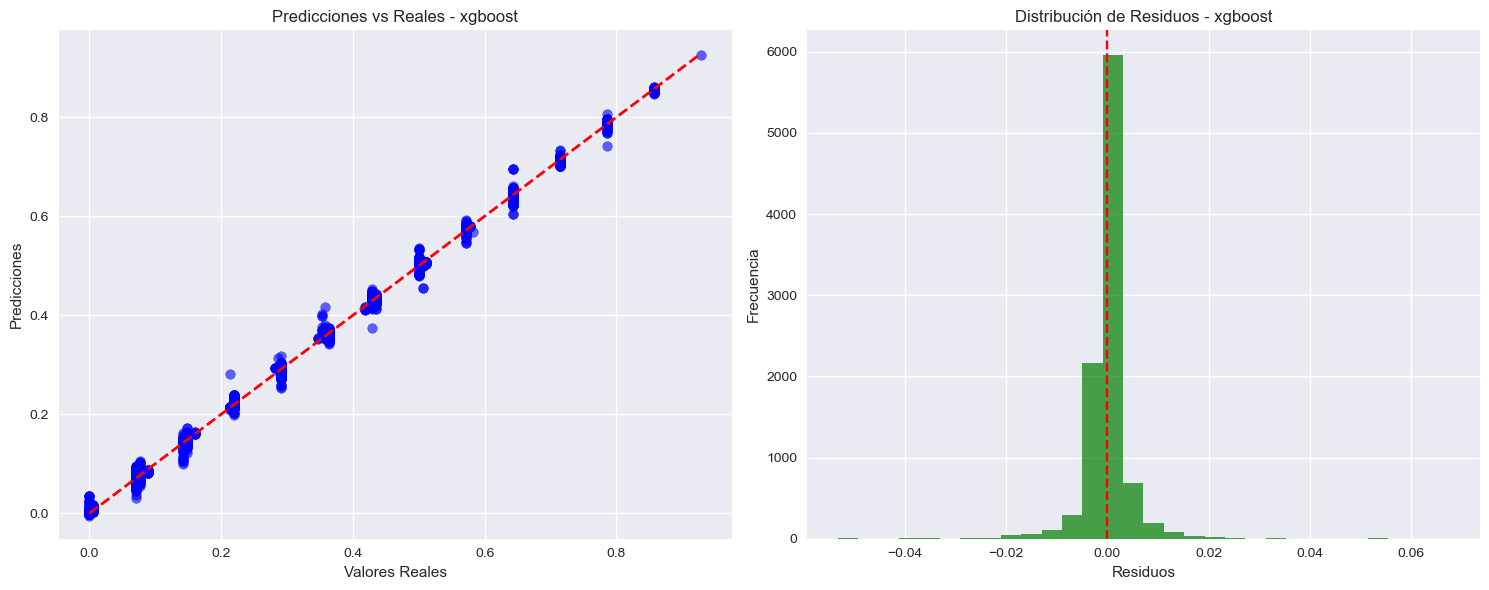


 ANÁLISIS DE RESIDUOS (xgboost):
   • Media de residuos: -0.000012
   • Desviación estándar: 0.0047
   • Residuos dentro de ±1σ: 87.1%

 ANÁLISIS DE IMPORTANCIA DE FEATURES


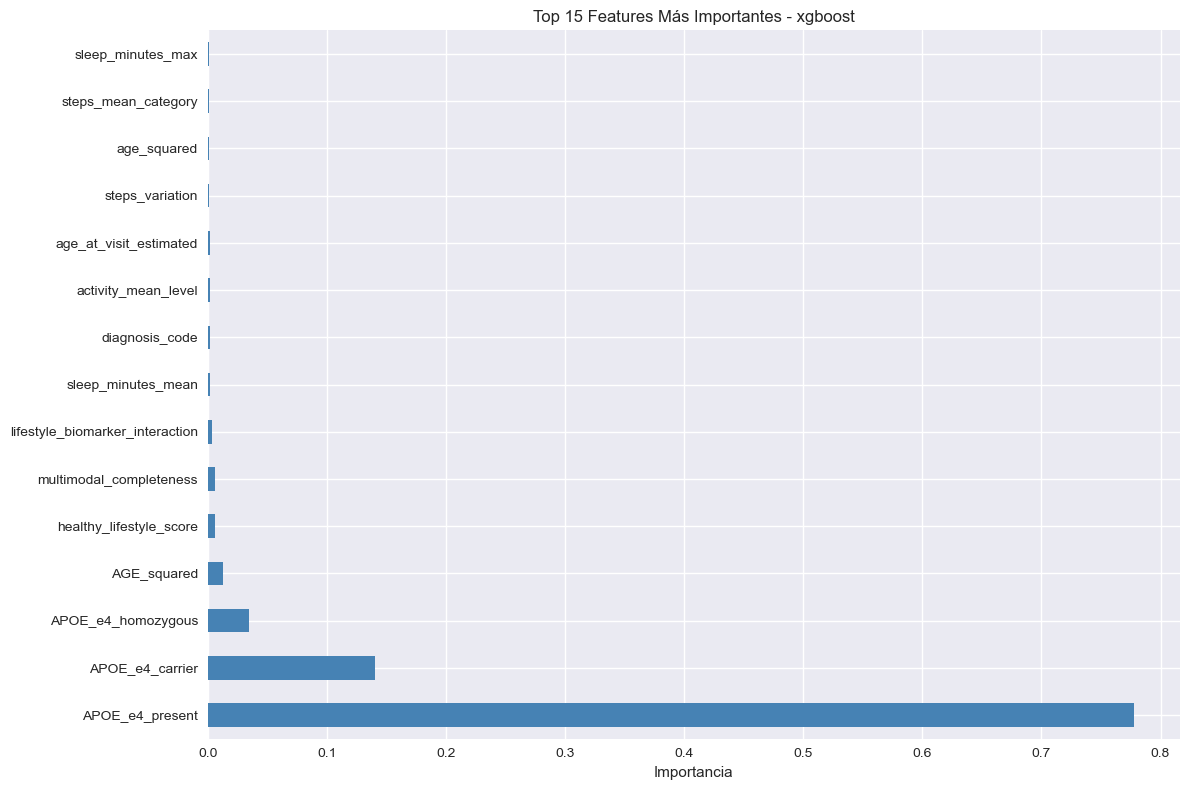

🔝 TOP 10 FEATURES MÁS IMPORTANTES:
    1. APOE_e4_present: 0.7775
    2. APOE_e4_carrier: 0.1405
    3. APOE_e4_homozygous: 0.0344
    4. AGE_squared: 0.0131
    5. healthy_lifestyle_score: 0.0061
    6. multimodal_completeness: 0.0058
    7. lifestyle_biomarker_interaction: 0.0037
    8. sleep_minutes_mean: 0.0021
    9. diagnosis_code: 0.0019
   10. activity_mean_level: 0.0015


In [16]:
# Obtener el mejor modelo
best_model_name, best_model, best_metrics = regression_pipeline.get_best_model(metric='r2_score')

# Obtener los datos de prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=regression_pipeline.test_size,
    random_state=regression_pipeline.random_state
)

# Hacer predicciones con el mejor modelo
y_pred = best_model.predict(X_test)

# Calcular residuos
residuals = y_pred - y_test

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot: Predicciones vs Valores reales
axes[0].scatter(y_test, y_pred, alpha=0.6, color='blue')
axes[0].plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 
             'r--', lw=2)
axes[0].set_xlabel('Valores Reales')
axes[0].set_ylabel('Predicciones')
axes[0].set_title(f'Predicciones vs Reales - {best_model_name}')

# Histograma de residuos
axes[1].hist(residuals, bins=30, alpha=0.7, color='green')
axes[1].set_xlabel('Residuos')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title(f'Distribución de Residuos - {best_model_name}')
axes[1].axvline(x=0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

print(f"\n ANÁLISIS DE RESIDUOS ({best_model_name}):")
print(f"   • Media de residuos: {residuals.mean():.6f}")
print(f"   • Desviación estándar: {residuals.std():.4f}")
print(f"   • Residuos dentro de ±1σ: {(np.abs(residuals) <= residuals.std()).mean()*100:.1f}%")

# Análisis de importancia de features
print("\n ANÁLISIS DE IMPORTANCIA DE FEATURES")
print("=" * 50)

try:
    # Verificar si el modelo tiene atributo de importancia
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
    elif hasattr(best_model, 'coef_'):
        importances = np.abs(best_model.coef_)
    else:
        raise AttributeError("El modelo no tiene atributo de importancia")
    
    # Crear serie de importancia
    feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)
    
    # Top 15 features más importantes
    top_features = feature_importance.head(15)
    
    plt.figure(figsize=(12, 8))
    top_features.plot(kind='barh', color='steelblue')
    plt.title(f'Top 15 Features Más Importantes - {best_model_name}')
    plt.xlabel('Importancia')
    plt.tight_layout()
    plt.show()
    
    print("🔝 TOP 10 FEATURES MÁS IMPORTANTES:")
    for i, (feature, importance) in enumerate(top_features.head(10).items(), 1):
        print(f"   {i:2d}. {feature}: {importance:.4f}")
        
except Exception as e:
    print(f"⚠️  No se pudo obtener importancia de features: {e}")

## Guardar resultados

In [19]:
# Guardar resultados
results_summary = {
    'experiment_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'best_model': best_overall,
    'best_r2_score': comparison_df.loc[best_overall, 'R² Score'],
    'best_rmse': comparison_df.loc[best_overall, 'RMSE'],
    'best_mae': comparison_df.loc[best_overall, 'MAE'],
    'total_features': X_train.shape[1],
    'training_samples': X_train.shape[0],
    'test_samples': X_test.shape[0]
}

# Guardar comparación de modelos
comparison_df.to_csv('../reports/model_results/regression_models_comparison.csv')
print(f"📁 Comparación guardada en: ../reports/model_results/regression_models_comparison.csv")

# Guardar resumen
with open('../reports/model_results/regression_results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"📁 Resumen guardado en: ../reports/model_results/regression_results_summary.json")

# Guardado del mejor modelo de regresión:
joblib.dump(best_model, '../models/pretrained/best_xgboost_model.pkl')
print(f"Mejor modelo guardado en: ../models/pretrained/best_xgboost_model.pkl")

📁 Comparación guardada en: ../reports/model_results/regression_models_comparison.csv
📁 Resumen guardado en: ../reports/model_results/regression_results_summary.json
Mejor modelo guardado en: ../models/pretrained/best_xgboost_model.pkl


In [20]:
print("\n" + "="*60)
print("🎯 RESUMEN DE MODELOS DE REGRESIÓN")
print("="*60)
print(f"✅ Modelos entrenados: {len(models_comparison)}")
print(f"🏆 Mejor modelo: {best_overall}")
print(f"📊 Mejor R² Score: {comparison_df.loc[best_overall, 'R² Score']:.4f}")
print(f"📉 Mejor RMSE: {comparison_df.loc[best_overall, 'RMSE']:.4f}")
print(f"📈 Features utilizadas: {X_train.shape[1]}")
print(f"🔄 Listo para optimización en Fase 5")
print("="*60)


🎯 RESUMEN DE MODELOS DE REGRESIÓN
✅ Modelos entrenados: 5
🏆 Mejor modelo: XGBoost
📊 Mejor R² Score: 0.9995
📉 Mejor RMSE: 0.0047
📈 Features utilizadas: 166
🔄 Listo para optimización en Fase 5


---

__Abraham Tartalos__